In [99]:
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader

In [100]:
class ResizeTransform:
    def __init__(self, new_width, new_height):
        self.new_width = new_width
        self.new_height = new_height

    def __call__(self, image, target):
        original_width, original_height = image.size
        scale_w = self.new_width / original_width
        scale_h = self.new_height / original_height

        resized_image = F.resize(image, (self.new_height, self.new_width))

        for box in target:
            bbox = box["bbox"]
            new_x_min = bbox[0] * scale_w
            new_y_min = bbox[1] * scale_h
            new_x_max = bbox[2] * scale_w
            new_y_max = bbox[3] * scale_h
            box["bbox"] = [new_x_min, new_y_min, new_x_max, new_y_max]

        return resized_image, target

In [90]:
def resize_and_scale(image, target):
    resize_transform = ResizeTransform(512, 512)
    image, target = resize_transform(image, target)
    image = transforms.ToTensor()(image)
    return image, target

In [91]:
coco_train = CocoDetection(root='images/train2017',
                           annFile='annotations/ann2017/instances_train2017.json',
                           transforms=resize_and_scale)

coco_val = CocoDetection(root='images/val2017',
                         annFile='annotations/ann2017/instances_val2017.json',
                         transforms=resize_and_scale)

loading annotations into memory...
Done (t=23.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [95]:
print('Number of samples in train:', len(coco_train))
print('Number of samples in validation:', len(coco_val))

img, target = coco_train[2]
print(target)
print(img.shape, target)

Number of samples in train: 118287
Number of samples in validation: 5000
[{'segmentation': [[267.38, 330.14, 281.81, 314.75, 299.12, 282.05, 281.81, 258.96, 248.14, 224.34, 242.37, 189.71, 213.52, 186.83, 237.56, 160.86, 214.48, 156.05, 224.1, 134.89, 204.86, 128.16, 204.86, 109.89, 209.67, 84.88, 228.91, 79.11, 254.88, 66.6, 319.32, 59.87, 301.04, 31.02, 328.93, 50.25, 353.94, 35.83, 389.53, 49.29, 429.92, 74.3, 451.08, 79.11, 454.93, 90.65, 453.01, 99.31, 459.74, 112.77, 456.85, 132.01, 453.01, 149.32, 442.43, 170.48, 432.81, 178.17, 430.89, 204.14, 410.69, 180.1, 399.15, 218.57, 386.64, 242.61, 358.75, 266.66, 350.09, 289.74, 363.56, 312.82, 388.57, 330.14, 374.14, 347.45, 324.13, 355.14, 263.53, 339.76, 269.3, 329.18]], 'area': 47675.66289999999, 'iscrowd': 0, 'image_id': 30, 'bbox': [163.88800000000003, 37.10803738317757, 203.904, 387.7323364485981], 'category_id': 64, 'id': 291613}, {'segmentation': [[394.34, 155.81, 403.96, 169.28, 403.96, 198.13, 389.53, 240.45, 364.52, 257.76,

In [96]:
def show_image(img_tensor, annotation):
    fig, ax = plt.subplots(1)
    ax.imshow(img_tensor.permute(1, 2, 0))

    for ann in annotation:
        bbox = ann['bbox']
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

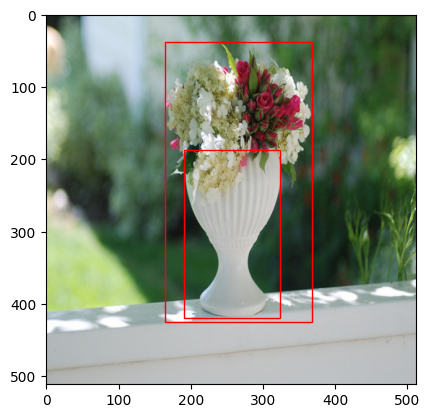

In [97]:
show_image(img, target)

In [98]:
train_loader = DataLoader(coco_train, batch_size=16, shuffle=True)
val_loader = DataLoader(coco_val, batch_size=16, shuffle=False)